In [0]:
Large_file_path = "dbfs:/FileStore/tables/large.json.gz"
Journal_file_path = "dbfs:/FileStore/tables/journal_information.csv"

journal_df = spark.read.format("csv").option("header", "true").load(Journal_file_path)
large_df = spark.read.format("json").load(Large_file_path)

In [0]:
# Load the data with inferSchema option
journal_df = spark.read.option("header", True).option("inferSchema", True).csv(Journal_file_path)
large_df = spark.read.option("header", True).option("inferSchema", True).json(Large_file_path)

journal_df.printSchema()
large_df.printSchema()


root
 |-- Journal Name: string (nullable = true)
 |-- ISSN: string (nullable = true)
 |-- EISSN: string (nullable = true)
 |-- Category & Journal Quartiles: string (nullable = true)
 |-- Citations: double (nullable = true)
 |-- JCI: double (nullable = true)
 |-- percentageOAGold: double (nullable = true)
 |-- IF: double (nullable = true)

root
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- authorId: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- citationcount: long (nullable = true)
 |-- corpusid: long (nullable = true)
 |-- externalids: struct (nullable = true)
 |    |-- ACL: string (nullable = true)
 |    |-- ArXiv: string (nullable = true)
 |    |-- CorpusId: string (nullable = true)
 |    |-- DBLP: string (nullable = true)
 |    |-- DOI: string (nullable = true)
 |    |-- MAG: string (nullable = true)
 |    |-- PubMed: string (nullable = true)
 |    |-- PubMedCentral: string (nullable = true)
 |-- in

In [0]:
"""Importing Necessary Libraries"""
from pyspark.sql.functions import count, countDistinct, desc, year
from pyspark.sql.functions import avg, size, col, explode, length, sum, expr
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu


In [0]:
"""1. Programmatically confirm that all papers have unique IDs 
        and output the number of papers in the file."""
def check_unique_ids(large_df):
    # Checking if all papers have unique IDs
    unique_ids_count = large_df.select(countDistinct("CorpusId")).collect()[0][0]
    total_papers_count = large_df.count()

    print("Total number of papers:", total_papers_count)
    print("Number of unique IDs:", unique_ids_count)

check_unique_ids(large_df)


Total number of papers: 150000
Number of unique IDs: 150000


In [0]:
# Checking for duplicate rows
duplicate_rows = large_df.count() - large_df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_rows}")


Number of duplicate rows: 0


In [0]:
# To check uniqueness with handling None values
"""Can be use to check externalids.ACL", "externalids.ArXiv", "externalids.DOI", 
              "externalids.DBLP", "externalids.MAG", "externalids.PubMed", 
              "externalids.PubMedCentral" all these ids"""

def check_uniqueness(df, column):
    total_count = df.count()
    non_null_count = df.filter(col(column).isNotNull()).count()
    unique_count = df.filter(col(column).isNotNull()).select(column).distinct().count()
    return unique_count == non_null_count, non_null_count
#check_uniqueness(large_df, "externalids.ArXiv")

# Example
unique_doi, doi_count = check_uniqueness(large_df, "externalids.DOI")
unique_arxiv, arxiv_count = check_uniqueness(large_df, "externalids.ArXiv")

print(f"All papers have unique DOIs: {unique_doi} (Non-null DOIs: {doi_count})")
print(f"All papers have unique ArXiv IDs: {unique_arxiv} (Non-null ArXiv IDs: {arxiv_count})")


All papers have unique DOIs: False (Non-null DOIs: 84544)
All papers have unique ArXiv IDs: True (Non-null ArXiv IDs: 1693)


In [0]:
#2. What is the average number of authors per paper?

def calculate_avg_authors_per_paper(large_df):
    # To calculate the average number of authors per paper
    avg_authors_per_paper = small_df.select(avg(size("authors"))).collect()[0][0]

    print("Average number of authors per paper:", avg_authors_per_paper)

calculate_avg_authors_per_paper(large_df)


Average number of authors per paper: 2.81628


+-------+-----------------+
|summary|     author_count|
+-------+-----------------+
|  count|           150000|
|   mean|          2.81628|
| stddev|6.556063873094105|
|    min|                0|
|    25%|                1|
|    50%|                2|
|    75%|                4|
|    max|             1012|
+-------+-----------------+



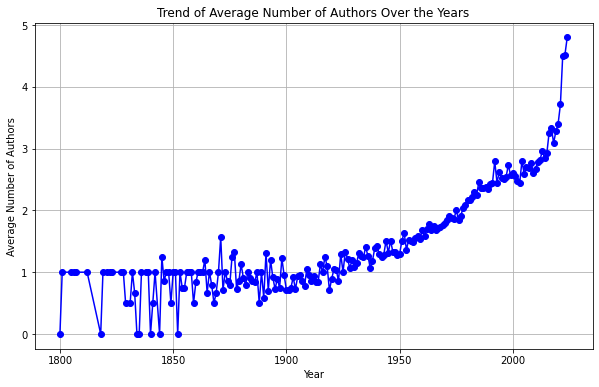

In [0]:
"""Distribution of Author Counts and Trends Over Time to know calculate the number of authors per paper"""
# To calculate the number of authors per paper
large_df = large_df.withColumn("author_count", size("authors"))

# summary statistics of author counts
author_count_summary = large_df.select("author_count").summary()
author_count_summary.show()

# to get the trend of average number of authors over the years
average_authors_per_year_df = large_df.groupBy("year").agg({"author_count": "avg"}).orderBy("year")


# year and average author count data
year_author_data = average_authors_per_year_df.collect()

# Extracting the year and average author count values
years = [row["year"] for row in year_author_data]
avg_author_counts = [row["avg(author_count)"] for row in year_author_data]

# Ploting the trend of average number of authors over the years
plt.figure(figsize=(10, 6))
plt.plot(years, avg_author_counts, marker='o', linestyle='-', color='blue')
plt.xlabel("Year")
plt.ylabel("Average Number of Authors")
plt.title("Trend of Average Number of Authors Over the Years")
plt.grid(True)
plt.show()


In [0]:
""" 3. How many different journals were the papers published in?"""

def count_different_journals(large_df):
    # Filtering out the null values and empty strings from the "journal" column
    df_cleaned = large_df.filter((col("journal.name").isNotNull()) & (col("journal.name") != ""))

    # Count the number of distinct journals
    distinct_journals_count = df_cleaned.select(countDistinct("journal.name")).collect()[0][0]

    print("Number of different journals:", distinct_journals_count)

count_different_journals(large_df)


Number of different journals: 33916


+--------------------+-----+
|                name|count|
+--------------------+-----+
|          ChemInform|  386|
|              Nature|  302|
|               ArXiv|  242|
|             Science|  217|
|British Medical J...|  208|
|            PLoS ONE|  178|
|          The Lancet|  150|
|    Reactions Weekly|  148|
|  Scientific Reports|  146|
|SSRN Electronic J...|  137|
+--------------------+-----+



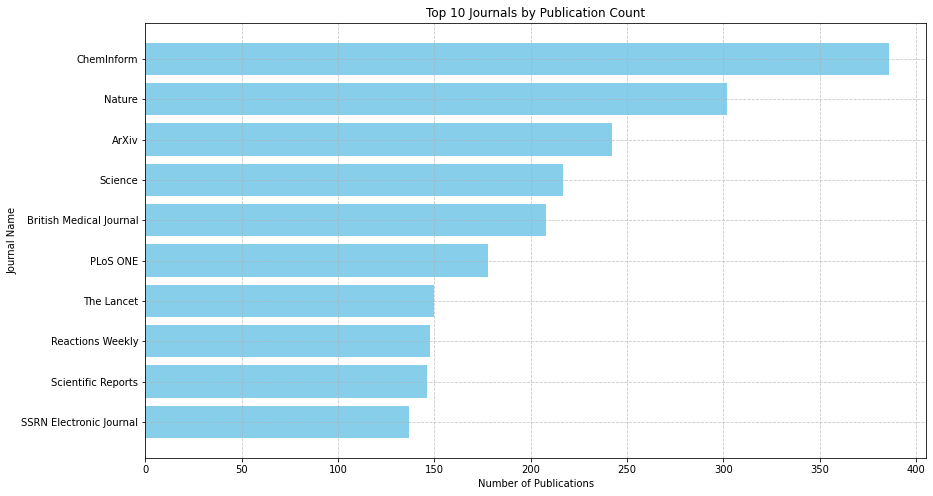

In [0]:
"""Top Journals by Publication Count"""
# Filter out rows where "journal.name" is null or empty
filtered_df = large_df.filter((col("journal.name").isNotNull()) & (length(col("journal.name")) > 0))

# Group by "journal.name" and count the occurrences
journal_publication_count = filtered_df.groupBy("journal.name").count().orderBy("count", ascending=False)

# Show the top 10 journals by publication count
top_10_journals = journal_publication_count.limit(10)
top_10_journals.show()

#preparind data for plot
journal_data = top_10_journals.collect()
journals = [row["name"] for row in journal_data]
publication_counts = [row["count"] for row in journal_data]

# ploting the top 10 journals by publication count
plt.figure(figsize=(14, 8))
plt.barh(journals, publication_counts, color='skyblue')
plt.xlabel("Number of Publications")
plt.ylabel("Journal Name")
plt.title("Top 10 Journals by Publication Count")
plt.gca().invert_yaxis()  # To display the journals in descending order of publication count
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [0]:
"""4. Find the 5 authors with the highest number of publications. 
        Give their names along with the number of publications they contributed to."""

def top_authors_by_publications(large_df):
    # Explode the authors array 
    df_authors = large_df.select(explode("authors").alias("author"))

    # Group by author id and name and count the number of publications per author
    author_publications_count = df_authors.groupBy("author.authorId", "author.name") \
                                          .agg(count("*").alias("publication_count"))

    top_5_authors = author_publications_count.orderBy(desc("publication_count")).limit(5)

    # Display the top 5 authors with the highest number of publications
    top_5_authors.show(truncate=False)


top_authors_by_publications(large_df)


+----------+---------------+-----------------+
|authorId  |name           |publication_count|
+----------+---------------+-----------------+
|2149377746|B. Noble       |23               |
|88842366  |Z. Soroko      |16               |
|90537224  |S. Sukhoruchkin|16               |
|49898687  |M. Kumar       |15               |
|49611617  |M. Jain        |10               |
+----------+---------------+-----------------+



In [0]:
"""Collaborative Patterns by Field"""
def analyze_collaborative_patterns(large_df):
    # Exploding the array of fields of study to have one row per field
    df_exploded = large_df.select(explode("s2fieldsofstudy.category").alias("field"), "authors")

    # Group by the field of study & calculate the average number of authors/publication
    avg_authors_per_publication = df_exploded.groupBy("field") \
                                              .agg(avg(size("authors")).alias("avg_authors_per_publication")) \
                                              .orderBy("avg_authors_per_publication", ascending=False)

    # Dispalying top 10 fields in which the most collaborations involved
    
    avg_authors_per_publication.show(10)


analyze_collaborative_patterns(large_df)

+--------------------+---------------------------+
|               field|avg_authors_per_publication|
+--------------------+---------------------------+
|             Physics|           4.12089132849768|
|            Medicine|          4.119492829820631|
|             Biology|          3.926306159788575|
|   Materials Science|         3.6578191356482637|
|           Chemistry|          3.644621295279912|
|Environmental Sci...|         3.2679408796818423|
|Agricultural and ...|         3.0538302277432714|
|         Engineering|         2.9410056857131335|
|             Geology|          2.888384512683578|
|    Computer Science|          2.766633408601586|
+--------------------+---------------------------+
only showing top 10 rows



In [0]:
journal_df1.show(10)

+--------------------+---------+---------+----------------------------+---------+-----+----------------+-------+
|        Journal Name|     ISSN|    EISSN|Category & Journal Quartiles|Citations|  JCI|percentageOAGold|     IF|
+--------------------+---------+---------+----------------------------+---------+-----+----------------+-------+
|                null|     null|     null|                        null|     null| null|            null|   null|
|CA-A CANCER JOURN...|0007-9235|1542-4863|         ONCOLOGY - SCIE(Q1)|  61124.0|76.09|            98.8| 286.63|
|              LANCET|0140-6736|1474-547X|        MEDICINE, GENERAL...| 403221.0|21.81|           22.12|203.231|
|NEW ENGLAND JOURN...|0028-4793|1533-4406|        MEDICINE, GENERAL...| 506069.0|22.26|             0.0|176.579|
|JAMA-JOURNAL OF T...|0098-7484|1538-3598|        MEDICINE, GENERAL...| 242479.0|10.32|            1.49|157.835|
|NATURE REVIEWS MO...|1471-0072|1471-0080|        CELL BIOLOGY - SC...|  66072.0| 8.39|         

In [0]:
combined_df = large_df.join(journal_df, large_df["journal.name"] == journal_df["Journal Name"], "left")

In [0]:
"""5. Find the top 5 authors with the highest cummulative impact factor.
       Output both the author information and the cummulative impact factor."""
def analyze_author_impact(large_df, journal_df):
    # Joining the DataFrames based on the journal name
    combined_df = large_df.join(journal_df, large_df["journal.name"] == journal_df["Journal Name"], "left")

    # Calculating the cumulative impact factor for each author
    author_impact_factor = combined_df.select(explode("authors").alias("author"), "IF") \
                                    .groupBy("author.authorId", "author.name") \
                                    .agg(sum("IF").alias("cumulative_impact_factor"))

    # Top 5 authors with the highest cumulative impact factor
    top_5_authors = author_impact_factor.orderBy(desc("cumulative_impact_factor")).limit(5)

    top_5_authors.show(truncate=False)
analyze_author_impact(large_df, journal_df)

+----------+------------+------------------------+
|authorId  |name        |cumulative_impact_factor|
+----------+------------+------------------------+
|2155504929|Ying Li     |93.832                  |
|144797099 |M. Viana    |92.238                  |
|5152451   |L. Andrade  |92.238                  |
|49900836  |H. Wood     |90.422                  |
|7695437   |A. M. Ruscio|87.899                  |
+----------+------------+------------------------+



+-----+-----------------+-----------------+---+------+----+------+-----+
|count|             mean|           stddev|min|   max|  q1|median|   q3|
+-----+-----------------+-----------------+---+------+----+------+-----+
|12424|4.408264407598207|6.669565987580215|0.5|286.63|1.98| 3.127|4.849|
+-----+-----------------+-----------------+---+------+----+------+-----+



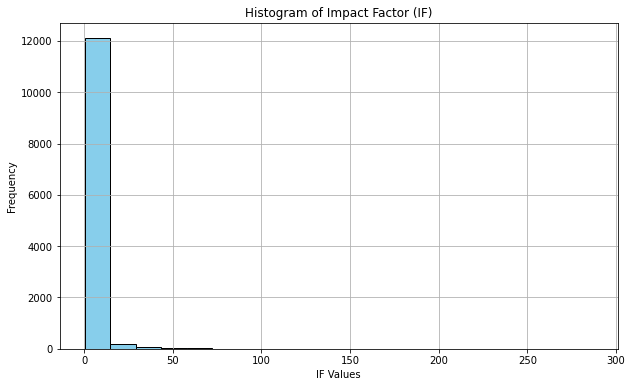

In [0]:
# Calculate various statistics for the 'IF' column

# Filter out rows where 'IF' column is not null
journal_df = journal_df.filter(col("IF").isNotNull())

if_stats = journal_df.selectExpr(
    "count(IF) as count",
    "mean(IF) as mean",
    "stddev_pop(IF) as stddev",
    "min(IF) as min",
    "max(IF) as max",
    "percentile_approx(IF, 0.25) as q1",
    "percentile_approx(IF, 0.50) as median",
    "percentile_approx(IF, 0.75) as q3"
)
# For displaying the statistics
if_stats.show()

# Extract 'IF' column as a list
IF_values = journal_df.select('IF').rdd.flatMap(lambda x: x).collect()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(IF_values, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('IF Values')
plt.ylabel('Frequency')
plt.title('Histogram of Impact Factor (IF)')
plt.grid(True)

plt.show()



In [0]:
"""Author Collaboration and Impact"""
# Create a new column to count the number of authors for each paper
combined_df = combined_df.withColumn("num_authors", size(col("authors")))

# Count the number of single-authored papers
single_authored_count = combined_df.filter(col("num_authors") == 1).count()

# Count the number of multi-authored papers
multi_authored_count = combined_df.filter(col("num_authors") > 1).count()

print("Number of Single-authored Papers:", single_authored_count)
print("Number of Multi-authored Papers:", multi_authored_count)


# Calculate the average impact factor for single-authored papers
single_author_avg_if = combined_df.filter(col("num_authors") == 1).agg({"IF": "avg"}).collect()[0][0]

# Calculate the average impact factor for multi-authored papers
multi_author_avg_if = combined_df.filter(col("num_authors") > 1).groupBy().agg({"IF": "avg"}).collect()[0][0]

print("Average Impact Factor for Single-authored Papers:", single_author_avg_if)
print("Average Impact Factor for Multi-authored Papers:", multi_author_avg_if)




Number of Single-authored Papers: 61856
Number of Multi-authored Papers: 84080
Average Impact Factor for Single-authored Papers: 4.924029002320188
Average Impact Factor for Multi-authored Papers: 5.632724210972239


In [0]:
""" Testing out the hypothesis using t-test and Mann-Whitney U test"""
"""Null Hypothesis (H0):
There is no significant difference in the impact factors between single-authored and multi-authored papers.

Alternative Hypothesis (H1):
There is a significant difference in the impact factors between single-authored and multi-authored papers."""

# Filter combined DataFrame to retain only rows where the "IF" column is not null
filtered_combined_df = combined_df.filter(~col("IF").isNull())

# Extract Impact Factor values for single-authored and multi-authored papers
single_authored_IF = filtered_combined_df.filter(col("num_authors") == 1).select("IF").collect()
multi_authored_IF = filtered_combined_df.filter(col("num_authors") > 1).select("IF").collect()

# Extract values from DataFrame collect() returns a list of Rows, so we extract the values
single_authored_IF = [row["IF"] for row in single_authored_IF]
multi_authored_IF = [row["IF"] for row in multi_authored_IF]

# Performing Mann-Whitney U test
statistic, p_value = mannwhitneyu(single_authored_IF, multi_authored_IF)

print("Mann-Whitney U Test:")
print("U-statistic:", statistic)
print("P-value:", p_value)

# Comparing p-value to significance level 
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference.")


Mann-Whitney U Test:
U-statistic: 1303109.5
P-value: 1.9496198195672495e-63
Reject the null hypothesis. There is a significant difference.


In [0]:
"""6. You’d like some additional information about publication trends. 
        How many publications with impact factor > 1 were published in each of the years between 2010-2020?"""

def count_publications_per_year(large_df, journal_df):
    # Joining the two DataFrames on the journal name
    combined_df = large_df.join(journal_df, large_df["journal.name"] == journal_df["Journal Name"], "left")

    # Filter publications with impact factor > 1 and publication year between 2010 and 2020
    filtered_df = combined_df.filter((combined_df["IF"].cast("float") > 1) & (combined_df["year"].between(2010, 2020)))
    
    publications_per_year = filtered_df.groupBy("year").count()

    publications_per_year = publications_per_year.orderBy("year")

    publications_per_year.show()

count_publications_per_year(large_df, journal_df)


+----+-----+
|year|count|
+----+-----+
|2010|  112|
|2011|  139|
|2012|  165|
|2013|  178|
|2014|  241|
|2015|  243|
|2016|  283|
|2017|  329|
|2018|  365|
|2019|  396|
|2020|  444|
+----+-----+



+----+---------------+-----------+--------------------+
|year|impactful_count|total_count|proportion_impactful|
+----+---------------+-----------+--------------------+
|2010|             18|         18|                 1.0|
|2011|             14|         16|               0.875|
|2012|             18|         18|                 1.0|
|2013|             26|         26|                 1.0|
|2014|             32|         34|  0.9411764705882353|
|2015|             45|         46|  0.9782608695652174|
|2016|             42|         42|                 1.0|
|2017|             47|         47|                 1.0|
|2018|             66|         67|  0.9850746268656716|
|2019|             56|         58|  0.9655172413793104|
|2020|             53|         53|                 1.0|
+----+---------------+-----------+--------------------+



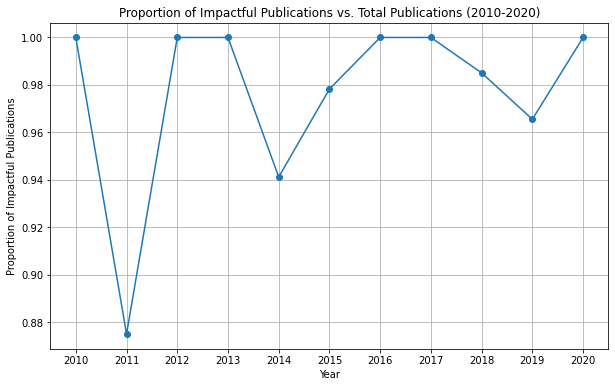

In [0]:
"""Comparison with Total Publications"""

# Filter publications between 2010 and 2020
filtered_df = combined_df.filter((year("publicationdate") >= 2010) & (year("publicationdate") <= 2020))

# Group by year and calculate count of impactful publications (IF > 1)
impactful_publications_count = filtered_df.filter(col("IF") > 1).groupBy(year("publicationdate").alias("year")) \
                                           .count() \
                                           .withColumnRenamed("count", "impactful_count")

# Group by year and calculate total count of publications
total_publications_count = filtered_df.groupBy(year("publicationdate").alias("year")) \
                                      .count() \
                                      .withColumnRenamed("count", "total_count")

# Merge the two DataFrames on year
combined_count_df = impactful_publications_count.join(total_publications_count, "year", "outer")

# Calculate the proportion of impactful publications to total publications for each year
combined_count_df = combined_count_df.withColumn("proportion_impactful", 
                                                 col("impactful_count") / col("total_count"))

# Sort by year
combined_count_df = combined_count_df.orderBy("year")
combined_count_df.show()

# Plotting the comparison
years = combined_count_df.select("year").collect()
proportions = combined_count_df.select("proportion_impactful").collect()

years = [row["year"] for row in years]
proportions = [row["proportion_impactful"] for row in proportions]

plt.figure(figsize=(10, 6))
plt.plot(years, proportions, marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Proportion of Impactful Publications")
plt.title("Proportion of Impactful Publications vs. Total Publications (2010-2020)")
plt.xticks(years)
plt.grid(True)
plt.show()

